<a href="https://colab.research.google.com/github/juwetta/DLI_Group-B/blob/main/TP074003_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount google drive and import dataset

Loading the Dataset: The dataset is loaded into a pandas DataFrame, and the features (X) and the target variable (y) are extracted. The features appear to include columns 3 to the second-to-last column, and the target variable is the last column.

In [2]:
# Importing the libraries
import numpy as np
import pandas as pd
import tensorflow as tf

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Importing the dataset
dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Assignment/URL_dataset_clean_balanced.csv')


display(dataset)


Mounted at /content/drive


,url,type
0,http://kitegacc.net/,phishing
1,https://www.electronichouse.com/article/ps3_ad...,legitimate
2,https://www.linkedin.com/in/larrymartinkimpel,legitimate
3,https://www.kansascity.com/2011/03/05/2700249/...,legitimate
4,https://www.en.wikipedia.org/wiki/Dem_Bones,legitimate
...,...,...
208871,http://www.apsweb.co.jp/wordpress/ihup/nD/inde...,phishing
208872,https://www.theruckus.wordpress.com/,legitimate
208873,http://jambidaily.com/34g3f3g/68k7jh65g.exe,phishing
208874,http://ejanla.co/43543r34r/843tf.exe,phishing


# Autoencoder + XGB

Dataset rows: 208876
Columns: ['url', 'type']
Extracting features from URLs...
Feature extraction done. Shape: (208876, 18)
Classes: ['legitimate', 'phishing']
Split sizes -- train: (167100, 18)  test: (41776, 18)
AE train/val shapes: (150390, 18) (16710, 18)
Training autoencoder...
Epoch 1/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4614 - val_loss: 0.0832
Epoch 2/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0863 - val_loss: 0.0488
Epoch 3/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0498 - val_loss: 0.0350
Epoch 4/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0299
Epoch 5/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0269 - val_loss: 0.0230
Epoch 6/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0212 - val_loss: 0.0187
Epoch 7/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.0146
Epoch 8/50
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0132
Epoch 9/50
294/294 ━━━━━━━━━

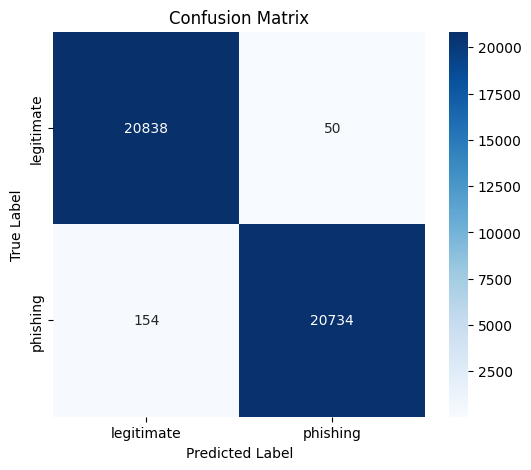

In [10]:
# Full leak-free pipeline: URL -> Autoencoder (FE) -> XGBoost (train via xgb.train with early stopping)

!pip install xgboost tensorflow

import os
import re
import numpy as np
import pandas as pd
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
import xgboost as xgb

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ----------- Load dataset -----------
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Assignment/URL_dataset_clean_balanced.csv'
df = pd.read_csv(DATA_PATH)

# Quick check
print("Dataset rows:", len(df))
print("Columns:", df.columns.tolist())

# ----------- Compact URL feature extraction -----------
def extract_url_features(url: str):
    # small, robust set of numeric features per URL — cheap & effective
    try:
        s = str(url)
        p = urlparse(s)
        host = p.hostname or ""
        path = p.path or ""
        query = p.query or ""
        lower = s.lower()
        feats = {
            "url_len": len(s),
            "host_len": len(host),
            "path_len": len(path),
            "query_len": len(query),
            "n_dots": lower.count('.'),
            "n_hyphens": lower.count('-'),
            "n_slash": lower.count('/'),
            "n_qmark": lower.count('?'),
            "n_eq": lower.count('='),
            "n_and": lower.count('&'),
            "n_at": lower.count('@'),
            "n_pct": lower.count('%'),
            "n_digits": sum(c.isdigit() for c in lower),
            "has_ip": 1 if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', host) else 0,
            "https": 1 if lower.startswith('https') else 0,
            "has_www": 1 if 'www' in host else 0,
            "n_params": (query.count('&') + (1 if '=' in query else 0)),
            "subdomains": max(0, len(host.split('.')) - 2) if host else 0,
        }
        return pd.Series(feats)
    except Exception:
        # safe fallback of zeros
        return pd.Series({
            "url_len":0,"host_len":0,"path_len":0,"query_len":0,"n_dots":0,"n_hyphens":0,
            "n_slash":0,"n_qmark":0,"n_eq":0,"n_and":0,"n_at":0,"n_pct":0,"n_digits":0,
            "has_ip":0,"https":0,"has_www":0,"n_params":0,"subdomains":0
        })

# Apply to dataset (this may take some time, but it's memory-efficient)
print("Extracting features from URLs...")
X_feats = df['url'].astype(str).apply(extract_url_features)
print("Feature extraction done. Shape:", X_feats.shape)

# ----------- Labels -----------
label_col = 'type'  # adjust if different
le = LabelEncoder()
y = le.fit_transform(df[label_col].astype(str))
print("Classes:", list(le.classes_))

# ----------- Train/Test split (80/20) -----------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_feats.values, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Split sizes -- train:", X_train_raw.shape, " test:", X_test_raw.shape)

# ----------- Scale (fit on train ONLY) -----------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# ----------- Further split train -> train_sub / val_sub for autoencoder training -----------
X_train_sub, X_val_sub = train_test_split(X_train, test_size=0.10, random_state=SEED)  # 10% of train for AE val
print("AE train/val shapes:", X_train_sub.shape, X_val_sub.shape)

# ----------- Autoencoder (train on X_train_sub, validate on X_val_sub) -----------
input_dim = X_train.shape[1]
latent_dim = 12   # try 8/12/16; 12 is a good start

inputs = tf.keras.Input(shape=(input_dim,))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
z = layers.Dense(latent_dim, activation='linear', name='latent')(x)
x = layers.Dense(32, activation='relu')(z)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inputs, outputs)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

early_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

print("Training autoencoder...")
autoencoder.fit(
    X_train_sub, X_train_sub,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=(X_val_sub, X_val_sub),
    callbacks=[early_cb],
    verbose=1
)

# ----------- Extract latent features for train (full) and test -----------
encoder = models.Model(inputs, autoencoder.get_layer('latent').output)
Z_train = encoder.predict(X_train, batch_size=4096, verbose=0)   # use full train (not just sub)
Z_test = encoder.predict(X_test, batch_size=4096, verbose=0)
print("Latent shapes:", Z_train.shape, Z_test.shape)

# ----------- For XGBoost: create train/validation split on latent space -----------
Z_train_sub, Z_val_sub, y_train_sub, y_val_sub = train_test_split(
    Z_train, y_train, test_size=0.10, random_state=SEED, stratify=y_train
)
print("XGB train/val shapes:", Z_train_sub.shape, Z_val_sub.shape)

# ----------- Prepare DMatrix and params for xgb.train (works across versions) -----------
dtrain = xgb.DMatrix(Z_train_sub, label=y_train_sub)
dval = xgb.DMatrix(Z_val_sub, label=y_val_sub)
dtest = xgb.DMatrix(Z_test, label=y_test)

params = {
    "objective": "binary:logistic" if len(le.classes_)==2 else "multi:softprob",
    "eval_metric": "logloss",
    "max_depth": 6,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": SEED,
    "tree_method": "hist"
}
if len(le.classes_) > 2:
    params["num_class"] = len(le.classes_)

evals = [(dtrain, "train"), (dval, "val")]

print("Training XGBoost with early stopping (xgb.train)...")
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=50
)

# ----------- Predict & Evaluate on clean TEST set -----------
# =========================================================
# STEP X: Evaluate Model (Classification Report + Confusion Matrix)
# =========================================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_auc_score
)
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

# ---------- Predictions ----------
y_pred_prob = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration + 1))

if len(le.classes_) == 2:  # Binary classification
    y_pred = (y_pred_prob > 0.5).astype(int)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
else:  # Multi-class
    y_pred = np.argmax(y_pred_prob, axis=1)
    roc_auc = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")

# ---------- Metrics ----------
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="macro")
recall = recall_score(y_test, y_pred, average="macro")
f1 = f1_score(y_test, y_pred, average="macro")

# Inference time (ms/sample)
start = time.time()
_ = xgb_model.predict(dtest, iteration_range=(0, xgb_model.best_iteration + 1))
inference_time = (time.time() - start) / len(y_test) * 1000

# ---------- Classification Report ----------
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Add extra metrics
report_df["ROC-AUC"] = roc_auc
report_df["Inference (ms)"] = inference_time
report_df["Params"] = f"n_estimators={xgb_model.best_iteration}"

# Round numeric columns
num_cols = report_df.select_dtypes(include=["float64", "int64"]).columns
report_df[num_cols] = report_df[num_cols].round(3)

print("\nClassification Report:\n")
print(report_df.to_string())

# ---------- Confusion Matrix ----------
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

